# [E-06]MovieReviewAnalysis

## 데이터 준비와 확인

In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}   
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(X_train) + list(X_test)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 데이터셋 내 문장 길이 분포 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 적절한 최대 문장 길이 지정
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 1. RNN 모델

### 모델 구성 및 validation set 구성

In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### Google Word2vec 사용 Embed모델

In [11]:
import os
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# embedding matrix 생성
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_embed_RNN = tf.keras.Sequential()
model_embed_RNN.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix), 
                                        input_shape=(None,)))
model_embed_RNN.add(tf.keras.layers.LSTM(8))
model_embed_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_embed_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_embed_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [12]:
# validation set 구성

# 3:2의 비율로 train 과 valid 데이터를 나눠준다.
# validation set 60000건 분리
X_val = X_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 86182건
partial_X_train = X_train[60000:]  
partial_y_train = y_train[60000:]

print(X_train.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(146182, 41)
(86182, 41)
(86182,)
(60000, 41)
(60000,)


### 모델 훈련 개시

In [13]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 5s 9ms/step - loss: 0.6161 - accuracy: 0.6641 - val_loss: 0.5211 - val_accuracy: 0.8274
Epoch 2/20
169/169 [==============================] - 1s 7ms/step - loss: 0.4885 - accuracy: 0.8396 - val_loss: 0.4801 - val_accuracy: 0.8373
Epoch 3/20
169/169 [==============================] - 1s 7ms/step - loss: 0.4417 - accuracy: 0.8552 - val_loss: 0.4616 - val_accuracy: 0.8336
Epoch 4/20
169/169 [==============================] - 1s 6ms/step - loss: 0.3965 - accuracy: 0.8626 - val_loss: 0.4057 - val_accuracy: 0.8323
Epoch 5/20
169/169 [==============================] - 1s 6ms/step - loss: 0.3273 - accuracy: 0.8695 - val_loss: 0.3784 - val_accuracy: 0.8377
Epoch 6/20
169/169 [==============================] - 1s 6ms/step - loss: 0.3073 - accuracy: 0.8775 - val_loss: 0.3751 - val_accuracy: 0.8405
Epoch 7/20
169/169 [==============================] - 1s 7ms/step - loss: 0.2964 - accuracy: 0.8816 - val_loss: 0.3727 - val_accuracy: 0.8400
Epoch 

In [14]:
results = model_RNN.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4900 - accuracy: 0.8321
[0.48997342586517334, 0.832068681716919]


### Embed 모델 훈련

In [15]:
model_embed_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = model_embed_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 3s 11ms/step - loss: 0.5747 - accuracy: 0.6938 - val_loss: 0.4768 - val_accuracy: 0.7878
Epoch 2/20
169/169 [==============================] - 1s 8ms/step - loss: 0.3818 - accuracy: 0.8393 - val_loss: 0.3726 - val_accuracy: 0.8395
Epoch 3/20
169/169 [==============================] - 1s 8ms/step - loss: 0.3307 - accuracy: 0.8654 - val_loss: 0.3637 - val_accuracy: 0.8443
Epoch 4/20
169/169 [==============================] - 1s 8ms/step - loss: 0.3065 - accuracy: 0.8776 - val_loss: 0.3599 - val_accuracy: 0.8466
Epoch 5/20
169/169 [==============================] - 1s 8ms/step - loss: 0.2881 - accuracy: 0.8869 - val_loss: 0.3633 - val_accuracy: 0.8458
Epoch 6/20
169/169 [==============================] - 1s 8ms/step - loss: 0.2753 - accuracy: 0.8936 - val_loss: 0.3639 - val_accuracy: 0.8447
Epoch 7/20
169/169 [==============================] - 1s 8ms/step - loss: 0.2604 - accuracy: 0.9012 - val_loss: 0.3835 - val_accuracy: 0.8441
Epoch

In [16]:
results = model_embed_RNN.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5000 - accuracy: 0.8261
[0.5000221133232117, 0.8260675072669983]


### Loss & Accuracy 그래프 시각화

In [17]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


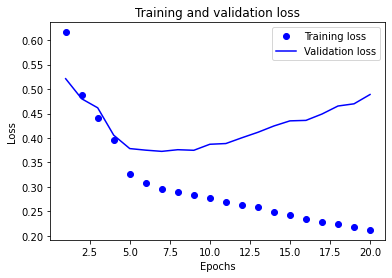

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')   # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss')   # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

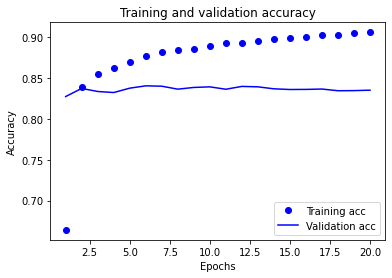

In [19]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding 모델 Loss & Accuracy 그래프

In [20]:
Embed_history_dict = Embed_history.history
print(Embed_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


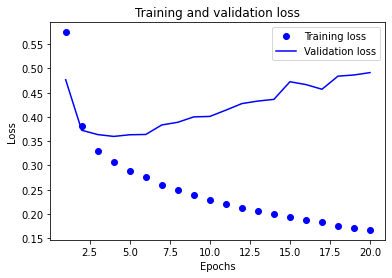

In [21]:
acc = Embed_history_dict['accuracy']
val_acc = Embed_history_dict['val_accuracy']
loss = Embed_history_dict['loss']
val_loss = Embed_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')   # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss')   # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

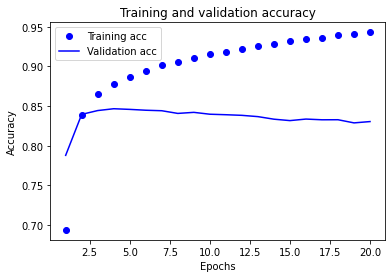

In [22]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 학습된 Embedding 레이어 분석

In [23]:
embedding_layer = model_embed_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [24]:
# 학습한 Embedding 파라미터 파일에 써서 저장
import os

word_vector_dim = 300

Embed_RNN_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/embed_rnn_file.txt'
f = open(Embed_RNN_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_embed_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
# 파라미터 확인
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(Embed_RNN_file_path, binary=False)
word_vectors.similar_by_word("love")

[('great', 0.6663508415222168),
 ('life', 0.5919533967971802),
 ('good', 0.5662117600440979),
 ('♡', 0.5207350254058838),
 ('we', 0.5185503959655762),
 ('Good', 0.5130147933959961),
 ('It', 0.4926430583000183),
 ('bad', 0.49219048023223877),
 ('that', 0.4761202037334442),
 ('very', 0.4659924805164337)]

## 2. 1DConv 모델

In [26]:
# 모델 구성
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_1DC = tf.keras.Sequential()
model_1DC.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim,  
                                        input_shape=(None,)))
model_1DC.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1DC.add(tf.keras.layers.MaxPooling1D(5))
model_1DC.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1DC.add(tf.keras.layers.GlobalMaxPooling1D())
model_1DC.add(tf.keras.layers.Dense(8, activation='relu'))
model_1DC.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_1DC.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Google Word2vec 사용 Embed모델

In [27]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# embedding matrix 생성
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_embed_1DC = tf.keras.Sequential()
model_embed_1DC.add(tf.keras.layers.Embedding(vocab_size, 
                                              word_vector_dim, 
                                              embeddings_initializer=Constant(embedding_matrix), 
                                              input_length=maxlen, 
                                              trainable=True))
model_embed_1DC.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_embed_1DC.add(tf.keras.layers.MaxPooling1D(5))
model_embed_1DC.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_embed_1DC.add(tf.keras.layers.GlobalMaxPooling1D())
model_embed_1DC.add(tf.keras.layers.Dense(8, activation='relu'))
model_embed_1DC.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_embed_1DC.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [28]:
# validation set 구성

# 3:2의 비율로 train 과 valid 데이터를 나눠준다.
# validation set 60000건 분리
X_val = X_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 86182건
partial_X_train = X_train[60000:]  
partial_y_train = y_train[60000:]

In [30]:
# 모델 학습
model_1DC.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_1DC.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model_1DC.evaluate(X_test, y_test, verbose=2)

print(results)

Epoch 1/20
169/169 [==============================] - 2s 7ms/step - loss: 0.0283 - accuracy: 0.9915 - val_loss: 1.0844 - val_accuracy: 0.8095
Epoch 2/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0234 - accuracy: 0.9932 - val_loss: 1.1196 - val_accuracy: 0.8090
Epoch 3/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 1.1785 - val_accuracy: 0.8060
Epoch 4/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 1.2323 - val_accuracy: 0.8062
Epoch 5/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 1.2563 - val_accuracy: 0.8052
Epoch 6/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0207 - accuracy: 0.9932 - val_loss: 1.3655 - val_accuracy: 0.8076
Epoch 7/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0246 - accuracy: 0.9915 - val_loss: 1.3358 - val_accuracy: 0.8029
Epoch 

### Embed 모델 훈련

In [31]:
model_embed_1DC.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = model_embed_1DC.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model_embed_1DC.evaluate(X_test, y_test, verbose=2)

print(results)

Epoch 1/20
169/169 [==============================] - 3s 12ms/step - loss: 0.6758 - accuracy: 0.5562 - val_loss: 0.5907 - val_accuracy: 0.6756
Epoch 2/20
169/169 [==============================] - 2s 9ms/step - loss: 0.4694 - accuracy: 0.7791 - val_loss: 0.4498 - val_accuracy: 0.7873
Epoch 3/20
169/169 [==============================] - 2s 9ms/step - loss: 0.3666 - accuracy: 0.8399 - val_loss: 0.3894 - val_accuracy: 0.8272
Epoch 4/20
169/169 [==============================] - 2s 9ms/step - loss: 0.3276 - accuracy: 0.8617 - val_loss: 0.4211 - val_accuracy: 0.8126
Epoch 5/20
169/169 [==============================] - 2s 9ms/step - loss: 0.3023 - accuracy: 0.8761 - val_loss: 0.3789 - val_accuracy: 0.8351
Epoch 6/20
169/169 [==============================] - 2s 9ms/step - loss: 0.2697 - accuracy: 0.8939 - val_loss: 0.3817 - val_accuracy: 0.8363
Epoch 7/20
169/169 [==============================] - 2s 9ms/step - loss: 0.2486 - accuracy: 0.9040 - val_loss: 0.3935 - val_accuracy: 0.8333
Epoch

### 학습된 Embedding 레이어 분석

In [32]:
embedding_layer = model_embed_1DC.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [33]:
# 학습한 Embedding 파라미터 파일에 써서 저장

word_vector_dim = 300

Embed_1DC_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/embed_1DC_file.txt'
f = open(Embed_1DC_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_embed_1DC.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
# 파라미터 확인

word_vectors = Word2VecKeyedVectors.load_word2vec_format(Embed_1DC_file_path, binary=False)
word_vectors.similar_by_word("love")

[('good', 0.6614394187927246),
 ('great', 0.6502703428268433),
 ('♡', 0.649832010269165),
 ('Good', 0.6493776440620422),
 ('very', 0.6063159704208374),
 ('♥', 0.5967795252799988),
 ('am', 0.5365420579910278),
 ('we', 0.532218337059021),
 ('ost', 0.48918256163597107),
 ('8', 0.48351341485977173)]

## 3. GlobalMaxPooling1D 모델

In [35]:
# 모델 구성
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_GMP = tf.keras.Sequential()
model_GMP.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        input_shape=(None,)))
model_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_GMP.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### Google Word2vec 사용 Embed모델

In [36]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# embedding matrix 생성
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_embed_GMP = tf.keras.Sequential()
model_embed_GMP.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                        input_length=maxlen, 
                                        trainable=True))
model_embed_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_embed_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_embed_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_embed_GMP.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [37]:
# validation set 구성

# 3:2의 비율로 train 과 valid 데이터를 나눠준다.
# validation set 60000건 분리
X_val = X_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 86182건
partial_X_train = X_train[60000:]  
partial_y_train = y_train[60000:]

In [38]:
# 모델 학습
model_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_GMP.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model_GMP.evaluate(X_test, y_test, verbose=2)

print(results)

Epoch 1/20
169/169 [==============================] - 1s 5ms/step - loss: 0.6233 - accuracy: 0.7515 - val_loss: 0.4955 - val_accuracy: 0.8098
Epoch 2/20
169/169 [==============================] - 1s 4ms/step - loss: 0.4116 - accuracy: 0.8297 - val_loss: 0.3782 - val_accuracy: 0.8337
Epoch 3/20
169/169 [==============================] - 1s 4ms/step - loss: 0.3382 - accuracy: 0.8574 - val_loss: 0.3591 - val_accuracy: 0.8424
Epoch 4/20
169/169 [==============================] - 1s 4ms/step - loss: 0.3035 - accuracy: 0.8752 - val_loss: 0.3558 - val_accuracy: 0.8445
Epoch 5/20
169/169 [==============================] - 1s 4ms/step - loss: 0.2779 - accuracy: 0.8878 - val_loss: 0.3588 - val_accuracy: 0.8456
Epoch 6/20
169/169 [==============================] - 1s 4ms/step - loss: 0.2570 - accuracy: 0.8981 - val_loss: 0.3654 - val_accuracy: 0.8447
Epoch 7/20
169/169 [==============================] - 1s 4ms/step - loss: 0.2393 - accuracy: 0.9062 - val_loss: 0.3748 - val_accuracy: 0.8436
Epoch 

### Embed 모델 훈련

In [39]:
# 모델 학습
model_embed_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_embed_GMP.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model_embed_GMP.evaluate(X_test, y_test, verbose=2)

print(results)

Epoch 1/20
169/169 [==============================] - 2s 7ms/step - loss: 0.6384 - accuracy: 0.6856 - val_loss: 0.5441 - val_accuracy: 0.7964
Epoch 2/20
169/169 [==============================] - 1s 6ms/step - loss: 0.4592 - accuracy: 0.8196 - val_loss: 0.4058 - val_accuracy: 0.8268
Epoch 3/20
169/169 [==============================] - 1s 6ms/step - loss: 0.3624 - accuracy: 0.8479 - val_loss: 0.3660 - val_accuracy: 0.8390
Epoch 4/20
169/169 [==============================] - 1s 6ms/step - loss: 0.3211 - accuracy: 0.8665 - val_loss: 0.3530 - val_accuracy: 0.8443
Epoch 5/20
169/169 [==============================] - 1s 6ms/step - loss: 0.2928 - accuracy: 0.8802 - val_loss: 0.3493 - val_accuracy: 0.8443
Epoch 6/20
169/169 [==============================] - 1s 6ms/step - loss: 0.2701 - accuracy: 0.8913 - val_loss: 0.3469 - val_accuracy: 0.8461
Epoch 7/20
169/169 [==============================] - 1s 6ms/step - loss: 0.2491 - accuracy: 0.9016 - val_loss: 0.3481 - val_accuracy: 0.8475
Epoch 

### 학습된 Embedding 레이어 분석

In [40]:
embedding_layer = model_embed_GMP.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [41]:
# 학습한 Embedding 파라미터 파일에 써서 저장

word_vector_dim = 300

Embed_GMP_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/embed_GMP_file.txt'
f = open(Embed_GMP_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_embed_GMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [42]:
# 파라미터 확인

word_vectors = Word2VecKeyedVectors.load_word2vec_format(Embed_GMP_file_path, binary=False)
word_vectors.similar_by_word("love")

[('great', 0.46521663665771484),
 ('me', 0.39818862080574036),
 ('know', 0.3800278306007385),
 ('I', 0.3469514846801758),
 ('♡', 0.33543580770492554),
 ('good', 0.3287592828273773),
 ('Good', 0.32120078802108765),
 ('best', 0.3096315264701843),
 ('boring', 0.30048200488090515),
 ('bad', 0.28919368982315063)]

## 한국어 Word2Vec임베딩 활용하여 성능 개선

In [43]:
import gensim
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['집']
vector

/tmp/ipykernel_93/3008529413.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['집']


array([-1.319586  , -1.6629723 ,  0.1505883 ,  0.5035253 , -2.6690226 ,
       -1.0570946 ,  0.67788476,  2.796687  ,  1.4200262 , -0.39614034,
        1.9018966 ,  2.9973626 , -0.01318461,  0.35922977,  1.4223385 ,
        0.40999603, -0.42552626,  0.31498262,  0.87282205, -1.3778601 ,
       -0.1918586 ,  0.9000629 , -1.8640414 ,  0.8167136 , -1.7011755 ,
       -0.98501635,  0.66861403, -0.9031406 ,  0.3020793 ,  2.0629468 ,
       -0.31631446, -0.7964669 ,  0.11580559, -0.9859846 ,  0.7692624 ,
       -0.19869252,  0.56788325,  2.29683   ,  1.1519096 ,  1.5394832 ,
       -1.0729129 ,  0.1502994 ,  1.2680385 , -2.249592  , -0.8000674 ,
       -0.20292565, -0.40892753, -0.5215352 , -0.507804  , -1.3664671 ,
        0.42219886, -0.31854075,  0.2340286 , -0.77383935, -1.5936835 ,
        0.01904743,  1.177212  ,  1.6091572 , -0.5099399 ,  1.9581834 ,
       -0.34881008,  0.37763453, -0.01511123, -0.58241713,  0.40495008,
        0.8804171 ,  0.1846361 ,  1.0777823 , -0.7750021 , -1.00

In [44]:
word2vec.similar_by_word("행복")

/tmp/ipykernel_93/898241355.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("행복")


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

### 임베딩 매트릭스 생성

In [45]:
vocab_size = 10000   # 어휘 사전 크기
word_vector_dim = 200   # 워드 벡터 차원수

kor_embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        kor_embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_93/4108256183.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_93/4108256183.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  kor_embedding_matrix[i] = word2vec[index_to_word[i]]


### 모델 구성

In [62]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=Constant(kor_embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                    input_length=maxlen, 
                                    trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [63]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
# epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
epochs=10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    # batch_size=512,
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/10
337/337 [==============================] - 4s 8ms/step - loss: 0.6790 - accuracy: 0.5373 - val_loss: 0.5354 - val_accuracy: 0.7422
Epoch 2/10
337/337 [==============================] - 2s 7ms/step - loss: 0.4249 - accuracy: 0.8095 - val_loss: 0.3733 - val_accuracy: 0.8376
Epoch 3/10
337/337 [==============================] - 2s 7ms/step - loss: 0.3325 - accuracy: 0.8601 - val_loss: 0.3497 - val_accuracy: 0.8486
Epoch 4/10
337/337 [==============================] - 2s 7ms/step - loss: 0.2936 - accuracy: 0.8782 - val_loss: 0.3477 - val_accuracy: 0.8509
Epoch 5/10
337/337 [==============================] - 2s 7ms/step - loss: 0.2691 - accuracy: 0.8910 - val_loss: 0.3531 - val_accuracy: 0.8513
Epoch 6/10
337/337 [==============================] - 2s 7ms/step - loss: 0.2476 - accuracy: 0.9003 - val_loss: 0.3655 - val_accuracy: 0.8505
Epoch 7/10
337/337 [==============================] - 2s 7ms/step - loss: 0.2278 - accuracy: 0.9092 - val_loss: 0.3743 - val_accuracy: 0.8482
Epoch 

In [64]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4302 - accuracy: 0.8405
[0.4302257001399994, 0.8404906988143921]


### Loss & Accuracy 그래프 시각화

In [65]:
embed_history_dict = history.history
print(embed_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


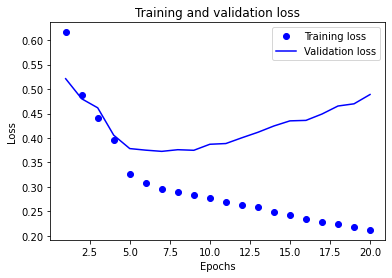

In [66]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

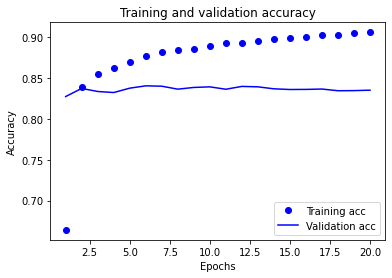

In [67]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

#### 처음 시도한 모델 1DCNN
* epoch=20 batch : 512 -> accuracy 0.818
* epoch=20 batch : 256 -> accuracy 0.822
* epoch=10 batch : 512 -> accuracy 0.823
* epoch=10 batch : 256 -> accuracy 0.823

epoch=10 에 batch 256 이 가장 적당하다 생각한다.  

#### 두번째 시도한 모델 RNN
accuracy 가 0.84 까지 가장 높이 올라갔다.  

그래프를 통해 epoch 수를 무작정 늘려도 좋은 것이 아님을 알게 되었다. 
모델 설계 과정 코드들이 전보다 조금 더 익숙해진 거 같다.  
어떤 것을 수정해야 모델 성능이 향상될지 궁금증이 생긴다.  
정확도를 85%까지 높이지 못했지만, 1-D CNN 모델 등을 함께 사용하면 향상될 것이라 생각한다.  
아직 레이어를 쌓고 설계하는 방법을 더 공부해서 시도해 봐야겠다.  

### 참고한 코드 링크
https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E9.%20Naver%20sentiment%20movie%20corpus%20Project.ipynb